# Computational Social Science Project #2 

**Enter your Name:**Kylee Hoffman

*Semester:* Fall 2024


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score


# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [2]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [3]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [5]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [6]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [7]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------

print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique()) 

['No Data']


In [8]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------

print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique()) 

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [9]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype(int) 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype(int) 

# Physical Inactivity
# ----------
diabetes = diabetes[diabetes['Physical_Inactivity_Number']!="No Data"] 
diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype(int) 


# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype('float64')

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [9]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [10]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [11]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['sex and age_total population_65 years and over_1',
 'sex and age_total population',
 'race_total population_one race_1',
 'sex and age_total population_18 years and over_1',
 'race_total population_two or more races_1',
 'hispanic or latino and race_total population']

In [12]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=duplicateColumnNames) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [13]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

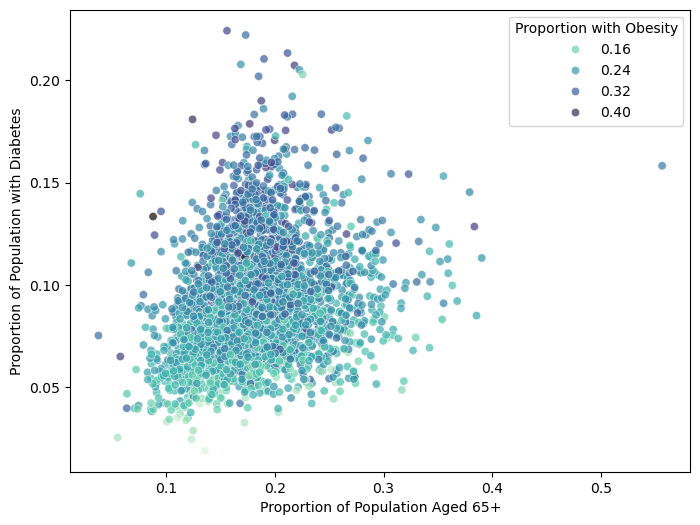

In [14]:
#
# EDA #1 and interpretations in this section 
#-----------
plt.figure(figsize=(8,6))
sns.scatterplot(x = "sex and age_total population_65 years and over",
                y = "Diabetes_Number",
                data = diabetes,
                hue = "Obesity_Number",
                alpha = 0.7,
                palette = "mako_r");
plt.xlabel("Proportion of Population Aged 65+")
plt.ylabel("Proportion of Population with Diabetes")
plt.legend(title = 'Proportion with Obesity')

The above plot explores the relationship between population age structure and diabetes prevalence. There is a slight positive relationship between older age structures and higher diabetes rates. This could indicate that counties with older populations will likely benefit more from the diabetes prevention program.

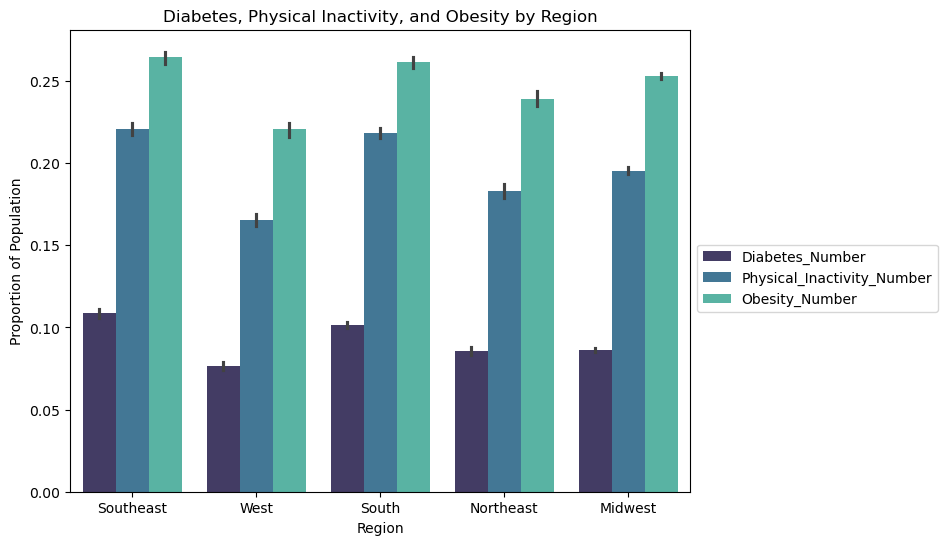

In [15]:
#
# EDA #2 and interpretations in this section 
#-----------
diabetes_melted = pd.melt(diabetes, id_vars='Region', 
                          value_vars=["Diabetes_Number", "Physical_Inactivity_Number", "Obesity_Number"], 
                          var_name='var', value_name='prop')

plt.figure(figsize=(8, 6))

# Side-by-side bars with 'dodge=True'
sns.barplot(x="Region", 
            y="prop", 
            hue="var", 
            data=diabetes_melted,
            palette='mako',
            dodge=True);
plt.title("Diabetes, Physical Inactivity, and Obesity by Region")
plt.ylabel("Proportion of Population")

plt.legend(title="", bbox_to_anchor=(1, 0.55), loc="upper left")

The second plot above shows physical inactivity, obesity, and diabetes prevalence by region. Counties in the West have lower proportions of each measure, while the Southeast and South have the highest levels. Each measure seems to be correlated the same in every region. This plot suggests that the South and Southeast should be the main targetss of the diabetes prevention program.

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [16]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                                columns = ["Region"],  
                                drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels =  ["County", "State"],
                               axis = 1) # drop columns

# look at first 10 rows of new data frame 
diabetes_clean.head(10) 

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [17]:
#
# Partition data
#-----------

# create y dataframe 
y = diabetes_clean.Diabetes_Number

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X  = diabetes_clean.drop(['Diabetes_Number', 'race alone or in combination with one or more other races_total population'], axis=1)

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [18]:
#
# Check features
#-----------

# X.columns

Dropped features (justification)  
- Race subcategories (This may be too specific and cause overfitting)  
- Race without ethnicity/multiple races (I simplified race so that there is one feature each for proportion non-Hispanic White, non-Hispanic Black, non-Hispanic AIAN, non-Hispanic asian, non-Hispanic API, and Hispanic. This provides clarity and reduces colinearity)  
- Citizen-voting age population (likely colinear with other age variables)  
- Sex-specific proportions (colinear with sex ratios)  
- Age categories except those with no upper or lower bounds (sort of redundant with the other age features)  
- Median age (not informative as it was divided by population count)  

In [19]:
#
# Feature selection
#-----------
X = X.drop(["race_total population", "hispanic or latino and race_total population_not hispanic or latino", 
            "sex and age_total population_male", "sex and age_total population_female", 
            "sex and age_total population_65 years and over_male", "sex and age_total population_65 years and over_female",
            "sex and age_total population_18 years and over_male", "sex and age_total population_18 years and over_female"] + 
            list(X.filter(regex="citizen|two or more races|one race|race alone|asian_|islander_|native_|mexican|puerto rican|cuban|other hispanic| to |median")), axis = 1)


In [20]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                   # specify training dataset
                                                    y,                   # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [21]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train,    # specify training dataset
                                                    y_train,             # specify test dataset
                                                    train_size=0.75,     # specify proportional split for training
                                                    test_size=0.25)      # specify proportional split for test

In [22]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

Standardization should occur after splitting the data into training and test sets so that data leakage does not occur.

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):**  
*Model 1: Linear Regression*: Linear regression is used to find a linear relationship between independent variables and a continuous dependent variable. Observations are assumed independent and linearity is assumed between the dependent and independent variables. Independent variables are not colinear.  
Pros: easy to understand, fast, simple  
Cons: limitations from assumptions, does not capture complex nonlinear relationships/multicollinearity  
Linear regression is a plausible choice for this problem as physical inactivity and obesity are linearly related to diabetes, diabetes proportions are continuous values, and linear regression is easy to explain to the public.  

*Model 2: Ridge regression*: Ridge regression extends linear regression by incorporating L2 regularization. Regularization helps minimize overfitting. Like linear regression, ridge assumes linearity between dependent and independent variables, and observations are independent of each other. However, multicollinearity is allowed with ridge regression.  
Pros: handles multicollinearity, predicts well  
Cons: choosing hyperparameters, more complex  
Ridge regression is plausible for this problem as it can handle any multicollinearity and a large number of variables.  

*Model 3: LASSO regression*: LASSO regression is another extension of linear regression. It is very similar to ridge regression, but uses L1 regularization rather than L2. One benefit of using LASSO over ridge is for feature importance. LASSO penalizes coefficients in a way that can shrink unnecessary features toward zero. This can lead to better predictions as only important features remain.  
Pros: handles multicollinearity, penalizes coeffitients, predicts well  
Cons: choosing hyperparameters, more complex  
LASSO regression is plausible for this problem as it has all of the strengths of ridge regression as well as the ability to help in feature selection.

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1: Linear Regression

In [23]:
#
# Model 1 training
#-----------

lin_reg = LinearRegression()                                 # create model

lin_model = lin_reg.fit(X_train, y_train)                    # fit the model

lin_reg_data = pd.DataFrame([lin_model.coef_, X.columns]).T  # create a dataframe from the estimates
lin_reg_data.columns = ['Coefficient', 'Feature']         

In [24]:
# tuning hyperparameters
param_grid = {'fit_intercept': [True, False]}           # use dictionary for tuning

# execute the grid search
lin_grid_reg = GridSearchCV(estimator  = lin_reg,     
                            param_grid = param_grid,   # parameters to be searched
                            cv=3)                      # 3-fold cross-validation

lin_grid_reg.fit(X_train, y_train)                     # fit tuning on training data

best_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])  # find the best performing model

In [25]:
# print the results  
print(lin_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lin_grid_reg.score(X_validate, y_validate))

{'fit_intercept': True}
Best CV R^2: 0.49887253686390776
Validation R^2: 0.45946446427043275


#### Model 2: Ridge regression

In [26]:
#
# Model 2 training
#-----------

ridge_reg = Ridge()                                              # create model

ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']         

In [27]:
# tuning hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(estimator  = ridge_reg,     
                            param_grid = param_grid,     # parameters to be searched
                            cv=3)                        # 3-fold cross-validation

ridge_grid_reg.fit(X_train, y_train)                     # fit tuning on training data

best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model

In [28]:
# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))

{'alpha': 0.9, 'fit_intercept': True, 'solver': 'auto'}
Best CV R^2: 0.49911842343752894
Validation R^2: 0.4601963600486717


#### Model 3: LASSO regression

In [29]:
#
# Model 3 training
#-----------

lasso_reg = Lasso(max_iter=15000)                                              # create model

lasso_model = lasso_reg.fit(X_train, y_train)                    # fit the model

lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T  # create a dataframe from the estimates
lasso_reg_data.columns = ['Coefficient', 'Feature']    

In [30]:
# specify the hyperparameters
param_grid = {'alpha': np.arange(0.001, 1, 0.01),
              'fit_intercept': [True, False],
              'selection': ['cyclic', 'random']}

# execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg,  
                              param_grid, # parameters to be searched
                              cv=3)       # 3-fold cross-validation

# now fit the tuning on the training data
lasso_grid_reg.fit(X_train, y_train)

best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])  # find the best performing model

In [31]:
# print the results  
print(lasso_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))

{'alpha': 0.001, 'fit_intercept': True, 'selection': 'cyclic'}
Best CV R^2: 0.4831260593278443
Validation R^2: 0.44397719879488395


## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

In [32]:
# create function to calculate the root mean squared errror
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

Validation RMSE:  0.019134425702851662


(0.026436960148837976,
 0.21639102400071356,
 0.03743425804834614,
 0.15923671121332872)

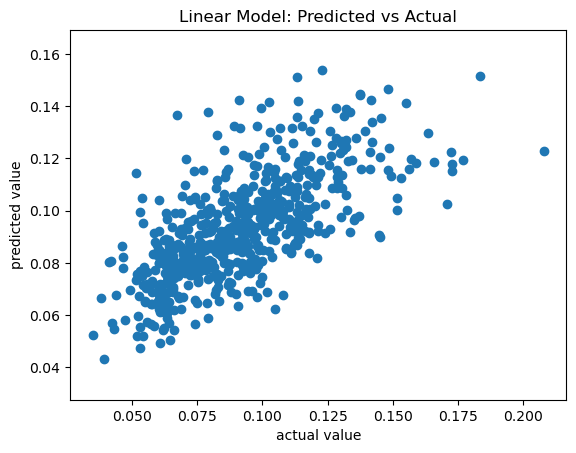

In [33]:
#
# Predict on validation data with linear model
#-----------
# select the best model to predict on validation dataset
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)

# results  
print('Validation RMSE: ', rmse(best_lin_pred, y_validate))

# plot the residuals on a scatter plot
plt.scatter(y_validate, best_lin_pred)               # specify x and y of the scatter plot
plt.title('Linear Model: Predicted vs Actual')       # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.axis('equal')

Validation RMSE 0.019121467119893328


(0.026436960148837976,
 0.21639102400071356,
 0.03711796974397209,
 0.15915354091044953)

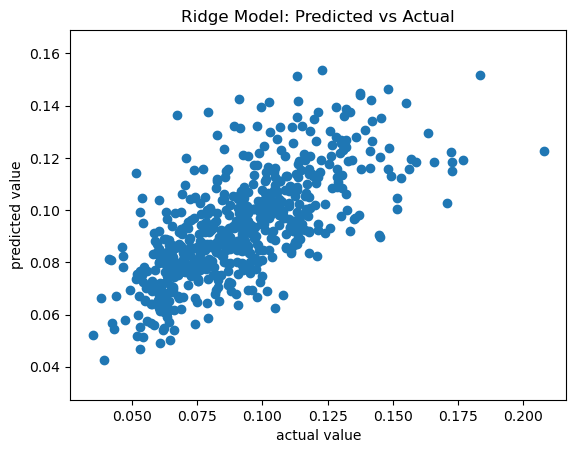

In [34]:
#
# Predict on validation data with ridge model
#-----------
# select the best model to predict on validation dataset
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)   # find best estimator and predict on validate

# print the results  
print('Validation RMSE', rmse(best_ridge_pred, y_validate))

# plot the residuals on a scatter plot
plt.scatter(y_validate, best_ridge_pred)                    # specify x and y of the scatter plot
plt.title('Ridge Model: Predicted vs Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.axis('equal')                                     

Validation RMSE 0.019406606831604476


(0.026436960148837976,
 0.21639102400071356,
 0.03688885610647806,
 0.16307418821789962)

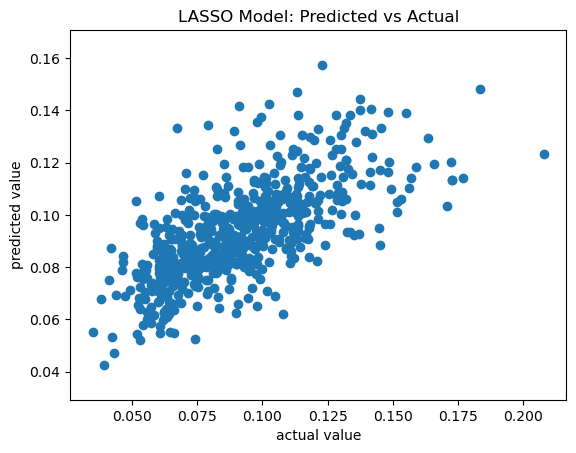

In [35]:
#
# Predict on validation data with LASSO model
#-----------
# select the best model to predict on validation dataset
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)   # find best estimator and predict on validate

# print the results  
print('Validation RMSE', rmse(best_lasso_pred, y_validate))

# plot the residuals on a scatter plot
plt.scatter(y_validate, best_lasso_pred)                    # specify x and y of the scatter plot
plt.title('LASSO Model: Predicted vs Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.axis('equal')                                     

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

Text(0.5, 1.0, 'Ridge Coefficients')

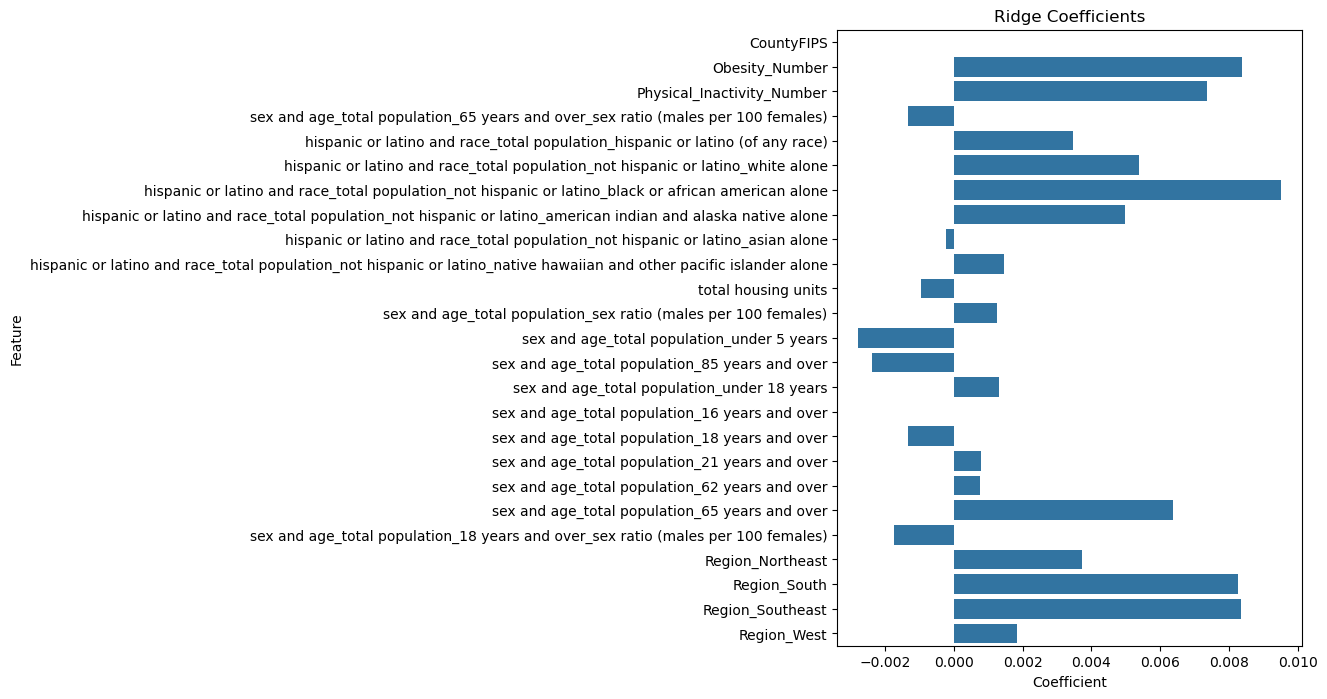

In [36]:
#
# Feature selection
#-----------
# Ridge predicted best on the validation set

# plot ridge coefficients to see feature importance
plt.figure(figsize=(6,8))
sns.barplot(x="Coefficient",                      
            y="Feature",                     
            data=ridge_reg_data).set_title("Ridge Coefficients")        

In [37]:
#
# Drop unimportant features and split data
#-----------

X = X.drop(["CountyFIPS", "sex and age_total population_16 years and over"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,  
                                                    y,        
                                                    train_size=0.8, 
                                                    test_size=0.2) 

In [38]:
#
# Retrain model
#-----------
tuned_ridge_reg = Ridge(alpha=0.9, fit_intercept=True, solver="auto") # hyperparameters from previous best model

ridge_model = tuned_ridge_reg.fit(X_train, y_train)

ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T       # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']                   # add column names for clarity

In [39]:
final_ridge_pred = ridge_model.predict(X_test)  

# print the results  
print('Test RMSE:', rmse(final_ridge_pred, y_test))

Test RMSE: 0.020825504428604733


### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [40]:
#
# Run cross-validation
#-----------
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import KFold

# KFold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize RidgeCV with KFold CV
ridge_cv = RidgeCV(cv=kf)

# Fit the model
ridge_cv.fit(X, y)

# Predict
final_predict = ridge_cv.predict(X)

In [41]:
#
# Evalute performance
#-----------
cv_scores = cross_val_score(ridge_cv, X, y, cv = 5)

test_score = ridge_cv.score(X, y)

# Print results
print("RMSE: ", rmse(final_predict, y))
print('Mean CV score (5-fold):', np.mean(cv_scores))         # Mean CV score
print('Test R^2:', test_score)                                 # Test R^2

RMSE:  0.019860770905871312
Mean CV score (5-fold): 0.4560150153857288
Test R^2: 0.5001929669147409


Tradeoffs in choice of k: a too high k will create too small of subsections to run tests on. A too low k will not create enough subsets.

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

The bias-variance tradeoff is the relationship between complexity and accuracy that defines how predictions get made on unseen data. Bias is the distance between predicted values and actual values. High bias occurs when a model is too simple to properly predict, which is called underfitting. Variance occurs when a model is over complicated and over fits to small fluctuations in the training data. High bias generally means low variance, where an overly simple model has high bias and low variance, and an overly complex model has low bias and high variance.  
The bias-variance tradeoff is relevant because finding the best balance creates the most accurate and generalizable results. In a scenario such as this project, highest accuracy is necesaary to ensur resources are allocated properly, and generalizability is important as counties across the countries vary greatly across the features used to predict. 

2. Define overfitting, and why it matters for machine learning. How can we address it?

Overfitting occurs when a model matches up too closely with training data. Overfitted models are too complex and fail to generalize well on test data. Overfitting matters in machine learning because it reduces a model's ability to make accurate predictions on new data. This can be particularily harmful when a model is attempting to predict outcomes relevant to society, such as public health interventions. Overfitting can be addressed by reducing the amount of features, regularizing features, using more data, or using ensemble methods.

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

Ridge regression performed marginally better than OLS and LASSO, with an RMSE of 0.01986 using k-fold cross validation, and 0.02065 using 80/20 train/test split. I think these results are pretty decent considering how small the dataset is and the limited set of features. My model's predictions suggest that diabetes prevelance is best estimated by physical inactivity levels, obesity levels, geographic region, and race/ethnicity. Sex and age are less important features. 
  
Based on the results, I would prioritize counties in the South and Southeast with high obesity and physical inactivity levels for the pilot program. My ridge regression model assigned the largest coefficient among race features to proportion black, which suggests that counties with a higher percent of black residents should be additionally prioritized. I do not think that age or sex are particularily relevant based on results. I would not be terribly confident in deploying this model in the real-world as I think other features need to be considered, such as existing public health spenditure.